# Differential analysis of protein expression from breast cancer
For this lesson, we will take the quantitative proteomics data from the following publication, "Proteogenomic Landscape of Breast Cancer Tumorigenesis and Targeted Therapy" (Cell, 2020). 
Here is the author's summary of the work:

The integration of mass spectrometry-based proteomics with next-generation DNA and RNA sequencing profiles tumors more comprehensively. Here this “proteogenomics” approach was applied to 122 treatment-naive primary breast cancers accrued to preserve post-translational modifications, including protein phosphorylation and acetylation. Proteogenomics challenged standard breast cancer diagnoses, provided detailed analysis of the ERBB2 amplicon, defined tumor subsets that could benefit from immune checkpoint therapy, and allowed more accurate assessment of Rb status for prediction of CDK4/6 inhibitor responsiveness. Phosphoproteomics profiles uncovered novel associations between tumor suppressor loss and targetable kinases. Acetylproteome analysis highlighted acetylation on key nuclear proteins involved in the DNA damage response and revealed cross-talk between cytoplasmic and mitochondrial acetylation and metabolism. Our results underscore the potential of proteogenomics for clinical investigation of breast cancer through more accurate annotation of targetable pathways and biological features of this remarkably heterogeneous malignancy.


Today we will use the underlying data to learn about what proteins are changing between the Luminal A and Luminal B samples of breast cancer that were examined in this study.

# Import the required libraries 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load the z-score normalized data into a pandas DataFrame 
This should point to where the csv file is located on your own computer

In [25]:
df = pd.read_csv('Z:/users/Pete Doubleday/2023_teaching/CPTAC_2020_BR_proteomics_annotated.csv', low_memory = False)
df.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10107 entries, 0 to 10106
Columns: 135 entries, id to LumA.56
dtypes: float64(126), int64(3), object(6)
memory usage: 10.4+ MB


# Move forward with only complete data
We will only take proteins that were identified in all samples, and exlude those with missing quantification values.

As an aside, some proteins may not be identified or quantified in a particular sample for a number of reasons. It is possible that the underlying biology of the tumor sample is different, or that the protein was below the limit of detection of the mass spectrometer used to identify the peptides from the given protein. Additionally, there are a number of possible explanaitions stemming from the analytical chemistry and the study design that we will not cover.

We could "gap-fill" these missing values using machine learning or simple imputation to include proteins with missing values; however, here with over 7,000 proteins quantified in union, it is  enough for us to move forward.

In [26]:
df.replace(r'\s+', np.nan, regex=True)
df.dropna(axis = 0, how = 'any', inplace = True)
df.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7767 entries, 0 to 10102
Columns: 135 entries, id to LumA.56
dtypes: float64(126), int64(3), object(6)
memory usage: 8.1+ MB


# Define and compare the two groups 
Here we will move forward with the tumors annotated clinically as luminal A and luminal B. Let's pull these out, and perform a t-test to generate p-values for all proteins quantified in luminal A and luminal B.

(You can also try with the other subtypes. To do this, you will need to look at the original table and look at the values)

In [27]:
Lum_A = df.filter(like = 'LumA')
Lum_B = df.filter(like = 'LumB')

In [28]:
# Perform a t-test on the normalized-data
t, p = ttest_ind(Lum_A, Lum_B, axis=1)

print(p)

[0.42014438 0.16348083 0.87162223 ... 0.05123831 0.62202192 0.17925879]


# Use the Benjamini-Hochberg procedure to correct for multiple hypothesis testing.
To move forward, we need to correct for multiple hypothesis testing. Consider that if we were only looking at the expression of the Estrogen Receptor (ESR1), for example, we would only need to compare the expression of this one gene across samples. However, consider that we are trying to assert whether any of the >7,000 proteins identified change signicantly between the two cancer subtypes, so instead of one statistical test, we are performing thousands.

If we have a p-value of 0.02 for a single statistical test, that would mean that if our null hypothesis is true, there would only be a 2% chance of obtaining our observed test statistic or a more extreme result. Since this is a small probability, we could reject our null hypothesis and say that the means are significantly different. However, if we want to find significant changes in many features in a large dataset, where we have thousands of statistical tests, we have a higher probability of false positives.

We can correct for this using the Benjamini-Hochberg (BH) correction. This is done by i) getting all p-values, ii) arranging the p-values from smallest to largest and assigning a rank to each one, and iii) calculating the Benjamini-Hochberg critical value for each p-value. 

Calculating the critical values is done with the following equation:

padj = (i/m)*Q

where the adjusted p-value, padj, is equal to i,the rank of the p-value, divided by m, the total number of tests, multiplied by the chosen false discovery rate, Q. 

For this statistical test, we define the stringency of Q, the false discovery rate, as 0.05 in a later step. This means we have a 5% expected false-postive rate, even with correction. We could change this to 1% or 10%, for example.

Let's also perform the full differential expression analysis without multiple hypothesis testing to understand what happens when we do not correct for many tests...

In [29]:
p_adj = np.multiply(p, len(p) / np.arange(len(p), 0, -1))

p_unadj = p



What does this adjustment actually do to our p-values?

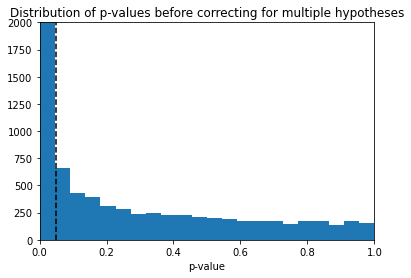

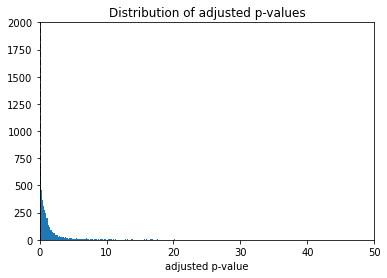

In [30]:
plt.hist(np.ndarray.tolist(p_unadj), bins='auto')
plt.axvline(x=0.05, linestyle="--", color="black")
plt.title("Distribution of p-values before correcting for multiple hypotheses")
plt.xlabel("p-value")
plt.xlim([0, 1])
plt.ylim([0,2000])
plt.show()

plt.hist(np.ndarray.tolist(p_adj), bins='auto')
plt.axvline(x=0.05, linestyle="--", color="black")
plt.title("Distribution of adjusted p-values")
plt.xlabel("adjusted p-value")
plt.xlim([0, 50])
plt.ylim([0,2000])
plt.show()

Let's plot adjusted p-values compared to p-values and see visually what happens in a bit more detail. For this figure, we will bound the figure limits by 1, however, note that adjusting p-values leads to values much higher than this.

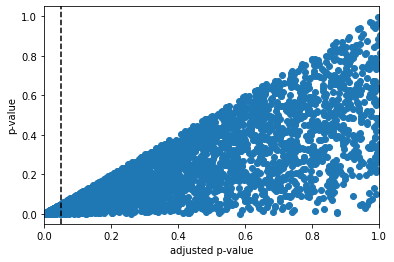

In [31]:
plt.scatter(p_adj, p_unadj)
plt.xlim([0, 1])
plt.axvline(x=0.05, linestyle="--", color="black")
#plt.axvline(y=0.05, linestyle="--", color="black")
plt.xlabel("adjusted p-value")
plt.ylabel("p-value")
plt.show()

# Next, define a fold-change cutoff and get mean fold-changes for Luminal A vs Luminal B
Now that we have adjusted our statistical confidence for the number of statistical tests we performed, the next thing to do is to assert a fold-change. We assume that anything strongly upregulated or downregulated in Luminal A vs Luminal B is important for the underlying biology. Perhaps in luminal A, some signaling pathway or set of transcription factors is strongly upregulated to promote cancer cell proliferation or metastisis. 

Here we will say that anything that changes over 2-fold is significant and worth further bioinformatic investigation or follow up studies.

We will calculate the mean protein expression between the two groups for each of the 7,000+ quantified proteins:

0       -0.175088
4       -0.320910
6        0.046603
7        1.086099
8        1.242674
           ...   
10096    0.049198
10098   -0.496785
10099    0.691313
10101    0.323386
10102    0.297509
Length: 7767, dtype: float64


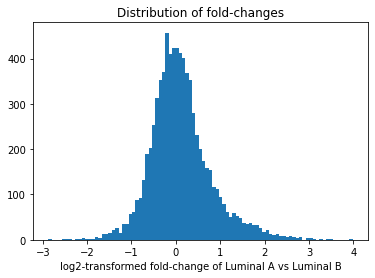

In [32]:
log2fc = np.mean(Lum_A, axis=1) - np.mean(Lum_B, axis=1)
print(log2fc)

plt.hist(log2fc, bins='auto')
plt.title("Distribution of fold-changes")
plt.xlabel("log2-transformed fold-change of Luminal A vs Luminal B")
plt.show()

fc_cutoff = 2.0
# also plot distribution of fold changes.....



# Get the list of differentially expressed proteins

Now let's get the list of proteins that meets both our criteria for statistical significance and fold change for when we have i) adjusted, and ii) non-adjusted p-values:

In [33]:
de_genes = np.logical_and(p_adj < 0.05, np.abs(log2fc) > np.log2(fc_cutoff))
de_genes_unadjusted = np.logical_and(p_unadj < 0.05, np.abs(log2fc) > np.log2(fc_cutoff))

With our adjusted p-values and fold-change, lets now plot what changes in between these two subtypes of breast cancer for the corrected data

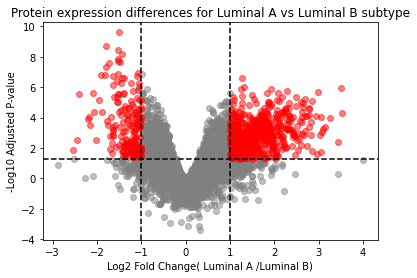

In [34]:
fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes], -np.log10(p_adj[~de_genes]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes], -np.log10(p_adj[de_genes]), c="red", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.05), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype")
plt.show()

let's plot what changes in between these two subtypes of breast cancer when no correction is applied:

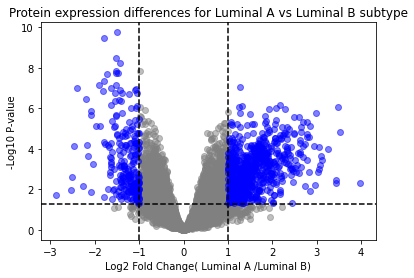

In [35]:
fig, ax = plt.subplots()
ax.scatter(log2fc[~de_genes_unadjusted], -np.log10(p_unadj[~de_genes_unadjusted]), c="gray", alpha=0.5)
ax.scatter(log2fc[de_genes_unadjusted], -np.log10(p_unadj[de_genes_unadjusted]), c="blue", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.05), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 P-value")
ax.set_title("Protein expression differences for Luminal A vs Luminal B subtype")
plt.show()

The plots look pretty similar, but when we use corrected values, we end up excluding a number of proteins as no longer significant. Indeed, now over 100 proteins have been excluded due to our correction for multiple hypothesis testing.

In [36]:
de_genes.sum()

768

In [37]:
de_genes_unadjusted.sum()

903

Let's now get the differentially expressed proteins as their own dataframe so we can look for biological significance between the two cancer subtypes:

In [38]:
# add differentially expressed genes, fold change, and adj-pvalues to the original df

# provide the full table without filtering...

df['de_genes'] = np.array(de_genes) # true/false column 
df['log2fc'] = np.array(log2fc)
df['adj_p'] = np.array(p_adj)

#get subset df where we only have differential expressed genes
DE_df = df.loc[df['de_genes'] == True]


In [39]:
print(DE_df)
# export df for the next steps...
df.to_csv('out.csv', index=False)
#DE_df.to_csv('out_DE.csv', index=False)

                   id geneSymbol  numColumnsProteinObserved  \
7         NP_001611.1      AHNAK                         17   
8         NP_076965.2      AHNAK                         16   
11        NP_958786.1       PLEC                         17   
18        NP_001714.1        DST                         17   
23     NP_001182461.1     SPTAN1                         17   
...               ...        ...                        ...   
9261      NP_002980.1      CCL21                         17   
9339      NP_003477.4     SLC7A5                         17   
9375   NP_001171605.1     CXCL12                         17   
9682   NP_001121070.1       IGF2                         17   
10012  NP_001288754.1      AZIN2                         15   

       numSpectraProteinObserved  protein_mw  percentCoverage  numPepsUnique  \
7                          15838    629603.7             78.8            668   
8                             49     16174.6             89.9             11   
11 

# Explore mRNA-level changes on your own

Note that protein- and mRNA-level data are collected in very different ways. For proteomics, the original proteins in the sample are enzymatically digested into peptides. These short peptides are then analyzed in a mass spectrometer, and bioinformatics is used to infer which proteins or protein isoforms the peptides come from, as well as the quantity of the original protein. For RNA-seq, extracted mRNAs are reverse-transcribed to cDNAs, which is then amplified before sequencing to get greater depth of coverage. 

1) Load in the RNA-seq data frame and perform differential analysis as above for Luminal A vs Luminal B by writing your own code.


In [43]:
df_rna = pd.read_csv('Z:/users/Pete Doubleday/2023_teaching/CPTAC_2020_BR_mRNA.csv', low_memory = False)
df_rna.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23121 entries, 0 to 23120
Columns: 124 entries, id to LumA.56
dtypes: float64(122), object(2)
memory usage: 21.9+ MB


2) At the RNA-level, move forward with the complete dataset and generate a histogram of fold-changes. (Note, the data is already log2-transformed). How many genes are in the complete dataset?

In [46]:
df_rna.replace(r'\s+', np.nan, regex=True)
df_rna.dropna(axis = 0, how = 'any', inplace = True)
df_rna.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10184 entries, 3 to 23120
Columns: 124 entries, id to LumA.56
dtypes: float64(122), object(2)
memory usage: 9.7+ MB


3        0.529137
7        0.682166
9       -0.092330
10       0.119621
18       0.439509
           ...   
23115   -0.247600
23117    0.232718
23118    0.207319
23119    0.226372
23120   -0.092459
Length: 10184, dtype: float64


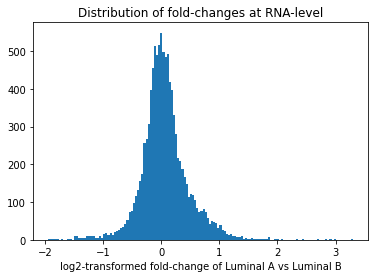

In [47]:
rna_A = df_rna.filter(like = 'LumA')
rna_B = df_rna.filter(like = 'LumB')

log2fc_rna = np.mean(rna_A, axis=1) - np.mean(rna_B, axis=1)
print(log2fc_rna)

plt.hist(log2fc_rna, bins='auto')
plt.title("Distribution of fold-changes at RNA-level")
plt.xlabel("log2-transformed fold-change of Luminal A vs Luminal B")
plt.show()

3) Report adjusted p-values.

In [48]:
t, p = ttest_ind(rna_A, rna_B, axis=1)

print(p)

[0.00864776 0.11474264 0.43067507 ... 0.35926073 0.12422595 0.60642791]


In [49]:
p_adj = np.multiply(p, len(p) / np.arange(len(p), 0, -1))

4) Report the number of differentially expressed RNAs at a 10% FDR-cutoff, with a log2 fold-change greater/less than 1.5. 

In [54]:
fc_cutoff_rna = 1.5

de_genes_rna = np.logical_and(p_adj < 0.1, np.abs(log2fc_rna) > np.log2(fc_cutoff_rna))
de_genes_rna.sum()
#not_de_genes_rna = ~de_genes_rna

979

5) Now change your code to report transcripts that are meet a 1% FDR-cutoff. What happens to the list of differentially expressed genes? 

In [62]:
de_genes_rna = np.logical_and(p_adj < 0.01, np.abs(log2fc_rna) > np.log2(fc_cutoff_rna))
de_genes_rna.sum()

442

6) Why do we consider a 1% cutoff more conservative than a 10% cutoff? What does this mean in terms of the number of false-positives we potentially deem as statistically significant? Do you think you would want to have a  stricter or looser FDR cutoff with an even larger dataset (ie., all 21,000 human genes), assuming a similar proportion of significant genes? Why or why not?

6 Answer: The 1% cutoff is more conservative because we accept more null hypotheses, and therefore reject more potential false positives. An FDR of 10% means that for all features called significant, 10% of these are truly null, while for a 1% FDR, 1% of the significant features are truly null.

If we have more features, then we have a larger total number statistical tests. If we have a 10% FDR for 1000 tests, we have potentially 100 false positives. If we had the same cutoff for 100,000 tests, then we have potentially 10,000 false positives! For a large dataset, we want to have a stricter FDR cutoff because of the number of tests, and the potential missinterpretation of so many false-positive hits. Maybe one could do follow-up studies on 10 genes, for example, but validating results for 10,000 potential false-postives could be untenable, and easily controlled for by simply being more strict with an FDR cutoff. 

7) Generate a volcano plot at a 1% FDR cutoff. Does the RNA-seq volcano plot look similar to the one generated from protein-level data? Do you expect overlap in the upregulated proteins and mRNAs?

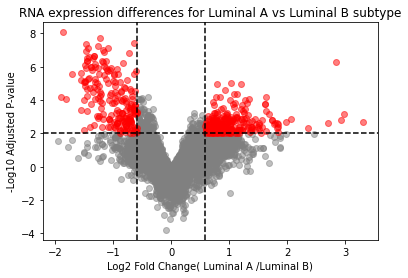

In [63]:
fig, ax = plt.subplots()
ax.scatter(log2fc_rna[~de_genes_rna], -np.log10(p_adj[~de_genes_rna]), c="gray", alpha=0.5)
ax.scatter(log2fc_rna[de_genes_rna], -np.log10(p_adj[de_genes_rna]), c="red", alpha=0.5)
ax.axvline(x=np.log2(fc_cutoff_rna), linestyle="--", color="black")
ax.axvline(x=-np.log2(fc_cutoff_rna), linestyle="--", color="black")
ax.axhline(y=-np.log10(0.01), linestyle="--", color="black")
ax.set_xlabel("Log2 Fold Change( Luminal A /Luminal B)")
ax.set_ylabel("-Log10 Adjusted P-value")
ax.set_title("RNA expression differences for Luminal A vs Luminal B subtype")
plt.show()

In [64]:
df_rna['de_genes'] = np.array(de_genes_rna)  
df_rna['log2fc'] = np.array(log2fc_rna)
df_rna['adj_p'] = np.array(p_adj)
print(df_rna)
df_rna.to_csv('out_rna.csv', index=False)

           id                                        description   Basal  \
3         A2M                              alpha-2-macroglobulin  5.3718   
7      A4GALT    alpha 1,4-galactosyltransferase (P blood group)  0.6260   
9        AAAS                       aladin WD repeat nucleoporin  4.7000   
10       AACS                         acetoacetyl-CoA synthetase  3.9448   
18      AADAT                      aminoadipate aminotransferase  3.8806   
...       ...                                                ...     ...   
23115    ZXDC                           ZXD family zinc finger C  5.1699   
23117  ZYG11B       zyg-11 family member B, cell cycle regulator  0.9835   
23118     ZYX                                              zyxin  5.9499   
23119   ZZEF1  zinc finger ZZ-type and EF-hand domain contain...  2.8499   
23120    ZZZ3                   zinc finger ZZ-type containing 3  3.6497   

       Basal.1  Basal.2  Basal.3  Basal.4    Her2    LumA  Her2.1  ...  \
3       5.325